In [1]:
%install-location $cwd/swift-install
%install '.package(path: "../../..")' Utils DifferentiableStep

Installing packages:
	.package(path: "../../..")
		Utils
		DifferentiableStep
With SwiftPM flags: []
Working in: /tmp/tmp1xe7i0on/swift-install
/home/sgugger/swift/usr/bin/swift-build: /home/sgugger/anaconda3/lib/libcurl.so.4: no version information available (required by /home/sgugger/swift/usr/lib/swift/linux/libFoundationNetworking.so)
[1/3] Compiling DifferentiableStep Scheduler.swift
[2/3] Compiling DifferentiableStep LearningRateFinder.swift
[3/4] Merging module DifferentiableStep
[4/6] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[5/7] Merging module jupyterInstalledPackages
[6/6] Linking libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


# Training loop examples

This notebook gives examples of use of the training loop designed in `DifferentiableStep`.

Imports:

In [2]:
import TensorFlow
import Utils
import DifferentiableStep

For plots:

In [3]:
import PythonKit

In [4]:
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")

In [5]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Data

The `Utils` module contains a mock dataset for a simple linear regression problem (useful for tests).

In [6]:
let data = RegressionData(entropy: ARC4RandomNumberGenerator(seed: 42))

Let's grab a batch of the validation set:

In [7]:
let batch = data.validationBatches.first { _ in true }!

In [8]:
(batch.data.shape, batch.label.shape)

▿ 2 elements
  ▿ .0 : [64]
    ▿ dimensions : 1 element
      - 0 : 64
  ▿ .1 : [64]
    ▿ dimensions : 1 element
      - 0 : 64


The elements of the dataset are tuples of floats (x, y) statisfying a relation `y = a * x + b` (with a bit of random noise added).

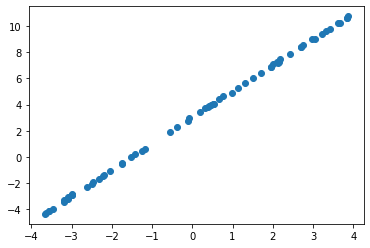

None


In [9]:
plt.figure(figsize: [6,4])
let npData = batch.data.makeNumpyArray()
let npLabels = batch.label.makeNumpyArray()
let fig = plt.scatter(npData, npLabels)
plt.show()

## Training loop

We need to define a model and an optimizer for that model. The `Utils` model contains a `RegressionModel` for this task:

In [10]:
let model = RegressionModel(a: 0.0, b: 0.0)
let optimizer = SGD(for: model, learningRate: 0.1)

Then we can combine the model, optimizer and the data in a `TrainingLoop`:

In [11]:
var trainingLoop = TrainingLoop(
  training: data.trainingEpochs, 
  validation: data.validationBatches, 
  model: model, 
  optimizer: optimizer,
  lossFunction: meanSquaredError)

We can train our model on the data directly using the `fit` method:

In [12]:
trainingLoop.fit(for: 3)

Let's check it learned something useful:

In [13]:
trainingLoop.model

▿ RegressionModel
  - a : 2.001678
  - b : 2.9960308


The ground truth values are 2 and 3, so we're close enough!

## Learning rate finder

We were lucky that the first learning rate we tried up there ended up working well. In general, you need to use the learning rate finder (or try lots of values). Let's reinitialize our training loop:

In [14]:
let model = RegressionModel(a: 0.0, b: 0.0)
let optimizer = SGD(for: model, learningRate: 0.1)
var trainingLoop = TrainingLoop(
  training: data.trainingEpochs, 
  validation: data.validationBatches, 
  model: model, 
  optimizer: optimizer,
  lossFunction: meanSquaredError)

Then let's use the `learningRateFinder` method:

In [15]:
let lrFinder = trainingLoop.learningRateFinder()

It returns the `TrainingLoopCallback` that stored the information we will need to pick a learning rate. The following function will plot that information.

In [16]:
public func plot(_ learningRateFinder: LearningRateFinder, dropLast: Int = 0){
  plt.figure(figsize: [6,4])
  let npLearningRates = np.array(learningRateFinder.learningRates.dropLast(dropLast))
  let npLosses = np.array(learningRateFinder.smoothedLosses.dropLast(dropLast))
  plt.xscale("log")
  plt.xlabel("learning rate")
  plt.ylabel("loss")    
  let fig = plt.plot(npLearningRates, npLosses)
  plt.show()
}

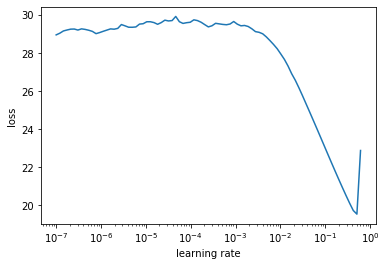

In [17]:
plot(lrFinder, dropLast: 1)

The learning rate finder launched a mock training changing the learning rate at each batch, from 1e-7 to 10. We can see there is a long period where nothing is happening because he learning rate is to slow. At 1e-3, training starts happening and is going very well in the range 1e-2 to 0.1 (the loss is decreasing a lot). Then just before 1, training suddenly diverges because the learning rate is too high.

As a general rule in this graph, you want to pick the point where the loss is the steepest, or the minimum of the curve divide by 10 (the minimum is already too high a value). Both criterions give us something like 3e-2 in our case.

## Other examples of callbacks:

You can change the behavior of the `TrainingLoop` using `TrainingLoopCallbacks`. In this design, those callbacks have read and write access. They can change any attributes of the training loop.

### Recorder

The Recorder computes and stores the training losses and validation losses, then prints them at the end of each epoch:

In [18]:
let model = RegressionModel(a: 0.0, b: 0.0)
let optimizer = SGD(for: model, learningRate: 0.1)

let recorder = Recorder()
var trainingLoop = TrainingLoop(
  training: data.trainingEpochs, 
  validation: data.validationBatches, 
  model: model, 
  optimizer: optimizer,
  lossFunction: meanSquaredError,
  callbacks: [recorder.handler])

In [19]:
trainingLoop.fit(for: 5)

Epoch 1 -- Training loss: 4.44, Validation loss: 0.11
Epoch 2 -- Training loss: 0.03, Validation loss: 0.00
Epoch 3 -- Training loss: 0.00, Validation loss: 0.00
Epoch 4 -- Training loss: 0.00, Validation loss: 0.00
Epoch 5 -- Training loss: 0.00, Validation loss: 0.00


And we can plot those losses:

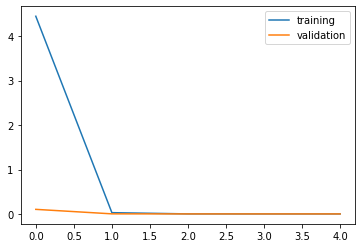

None


In [20]:
plt.figure(figsize: [6,4])
let npTrainingLosses = np.array(recorder.trainingLosses)
let npValidationLosses = np.array(recorder.validationLosses)
let _ = plt.plot(npTrainingLosses, label: "training")
let _ = plt.plot(npValidationLosses, label: "validation")
plt.legend()
plt.show()

The `Recorder` can also compute (and print out) metrics:

In [38]:
struct AlmostAccuracy: Metric {
  public var name: String { "AlmostAccuracy(\(threshold))" }
  let threshold: Float
  var sampleCount: Int = 0
  var corrects: Int = 0

  public var value: Float? {
    sampleCount == 0 ? nil : Float(corrects) / Float(sampleCount)
  }

  public init(threshold: Float) {
    self.threshold = threshold
  }

  public mutating func reset() {
    sampleCount = 0
    corrects = 0
  }

  public mutating func accumulate<Output, Target>(output: Output, target: Target) {
    guard let tensorOutput = output as? Tensor<Float> else { return }
    guard let tensorTarget = target as? Tensor<Float> else { return }
    sampleCount += tensorOutput.shape[0]
    let diff = abs(tensorOutput - tensorTarget)
    corrects += Int(Tensor<Int32>(diff .<= threshold).sum().scalarized())
  }
}

In [39]:
let model = RegressionModel(a: 0.0, b: 0.0)
let optimizer = SGD(for: model, learningRate: 0.1)

let recorder = Recorder(metrics: [AlmostAccuracy(threshold: 0.1)])
var trainingLoop = TrainingLoop(
  training: data.trainingEpochs, 
  validation: data.validationBatches, 
  model: model, 
  optimizer: optimizer,
  lossFunction: meanSquaredError,
  callbacks: [recorder.handler])

In [40]:
trainingLoop.fit(for: 5)

Epoch 1 -- Training loss: 4.44, Validation loss: 0.11, AlmostAccuracy(0.1): 0.00
Epoch 2 -- Training loss: 0.03, Validation loss: 0.00, AlmostAccuracy(0.1): 0.80
Epoch 3 -- Training loss: 0.00, Validation loss: 0.00, AlmostAccuracy(0.1): 0.98
Epoch 4 -- Training loss: 0.00, Validation loss: 0.00, AlmostAccuracy(0.1): 0.99
Epoch 5 -- Training loss: 0.00, Validation loss: 0.00, AlmostAccuracy(0.1): 0.98


### Scheduler

A scheduler will schedule the learning rate according to any function you like:

In [21]:
let model = RegressionModel(a: 0.0, b: 0.0)
let optimizer = SGD(for: model, learningRate: 0.1)

let recorder = Recorder()
var trainingLoop = TrainingLoop(
  training: data.trainingEpochs, 
  validation: data.validationBatches, 
  model: model, 
  optimizer: optimizer,
  lossFunction: meanSquaredError,
  callbacks: [recorder.handler,
              learningRateScheduler(makeSchedule(.cosine, from: 0.1, to: 0.0))])

In [22]:
trainingLoop.fit(for: 5)

Epoch 1 -- Training loss: 4.45, Validation loss: 0.12
Epoch 2 -- Training loss: 0.04, Validation loss: 0.01
Epoch 3 -- Training loss: 0.00, Validation loss: 0.00
Epoch 4 -- Training loss: 0.00, Validation loss: 0.00
Epoch 5 -- Training loss: 0.00, Validation loss: 0.00


### Changing the grad

Let's give an example where we change the gradients (real application: gradient clipping). Here let's pretend the a in our model comes from something pretrained and we don't want to train it at first, so we zero its gradient.

In [27]:
func zeroGrad<L: TrainingLoopProtocol>(_ loop: inout L, event: TrainingLoopEvent) throws 
where L.Model == RegressionModel {
  if event == .updateStart {
    var grad = loop.lastGradient!
    grad.a = .zero
    loop.lastGradient = grad
  }
}

In [28]:
let data = RegressionData(entropy: ARC4RandomNumberGenerator(seed: 42))
let model = RegressionModel(a: 1.5, b: 0.0)
let optimizer = SGD(for: model, learningRate: 0.1)

let recorder = Recorder()
var trainingLoop = TrainingLoop(
  training: data.trainingEpochs, 
  validation: data.validationBatches, 
  model: model, 
  optimizer: optimizer,
  lossFunction: meanSquaredError,
  callbacks: [recorder.handler, zeroGrad])

In [29]:
trainingLoop.fit(for: 5)

Epoch 1 -- Training loss: 3.84, Validation loss: 1.45
Epoch 2 -- Training loss: 1.36, Validation loss: 1.38
Epoch 3 -- Training loss: 1.33, Validation loss: 1.38
Epoch 4 -- Training loss: 1.34, Validation loss: 1.38
Epoch 5 -- Training loss: 1.33, Validation loss: 1.39


We can see the model ended with the right value for b but that the value for a has not changed during training:

In [30]:
trainingLoop.model

▿ RegressionModel
  - a : 1.5
  - b : 3.0352817


## Changing the differentiable step

For modifications of the training loop that intervene during the differentiable step, we don't have events to change the training loop. We need to write a custom differentiable step. Since the `TrainingLoop` relies on four generic types, the easiest way to write this training step is to make an extension on the training loop struct.

### Changing the loss

In [34]:
let data = RegressionData(entropy: ARC4RandomNumberGenerator(seed: 42))
let model = RegressionModel(a: 1.5, b: 0.0)
let optimizer = SGD(for: model, learningRate: 0.1)

let recorder = Recorder()
var trainingLoop = TrainingLoop(
  training: data.trainingEpochs, 
  validation: data.validationBatches, 
  model: model, 
  optimizer: optimizer,
  lossFunction: meanSquaredError,
  callbacks: [recorder.handler])

Here, let's give an example of regularizer that adds some kind of penalty to the loss:

In [35]:
extension TrainingLoop where Model == RegressionModel {
  mutating func regularizerDifferentiableStep() throws {
    guard let data = lastInput else { return }
    guard let target = lastTarget else { return }
    (lastLoss, lastGradient) = valueWithGradient(at: model) { (model: Model) -> Tensor<Float> in
      let predictions = model(data)
      lastOutput = predictions
      return lossFunction.f(predictions, target) + 0.1 * (model.a + model.b)
    }
  }
}

In [36]:
trainingLoop.fit(for: 5, differentiableStep: { try $0.regularizerDifferentiableStep() })

Epoch 1 -- Training loss: 3.02, Validation loss: 0.14
Epoch 2 -- Training loss: 0.53, Validation loss: 0.01
Epoch 3 -- Training loss: 0.50, Validation loss: 0.01
Epoch 4 -- Training loss: 0.50, Validation loss: 0.01
Epoch 5 -- Training loss: 0.50, Validation loss: 0.01


In [37]:
trainingLoop.model

▿ RegressionModel
  - a : 1.9949354
  - b : 2.9468217
